In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.compat.v1 as tfc

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
sess = tfc.InteractiveSession()

## Adjust CSV

In [2]:
#adjust names to fit
train_csv = "train.csv"
train_df = pd.read_csv(train_csv)
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

species_labels = list(train_df.species.unique())
images = train_df['image']
sid = train_df['individual_id']
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


amount of species: 26


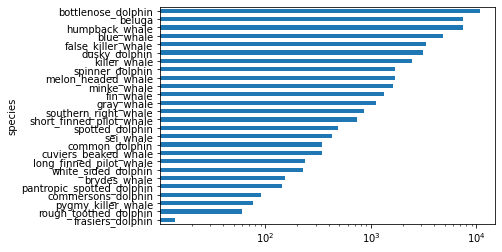

In [3]:
print(f"amount of species: {len(train_df.species.unique())}")
train_df.groupby(by='species').size().sort_values().plot.barh().set_xscale('log')

In [4]:
def get_id(sp):
    return species_labels.index(sp)
##encode species
train_df["species"] = train_df.apply(lambda row :get_id(row["species"]),axis = 1)

##one-hot encode species
#train_df = pd.concat([train_df, pd.get_dummies(train_df["species"],prefix='species_',drop_first=True)], axis = 1)
#train_df.drop(['species'],axis=1, inplace=True)
train_df

,image,species,individual_id
0,00021adfb725ed.jpg,0,cadddb1636b9
1,000562241d384d.jpg,1,1a71fbb72250
2,0007c33415ce37.jpg,2,60008f293a2b
3,0007d9bca26a99.jpg,3,4b00fe572063
4,00087baf5cef7a.jpg,1,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,4,5ac053677ed1
51029,fff8b32daff17e.jpg,17,1184686361b3
51030,fff94675cc1aef.jpg,7,5401612696b9
51031,fffbc5dd642d8c.jpg,4,4000b3d7c24e


## Input Pipeline

In [5]:
IMG_SIZE = 64

def process_img(img):
    img = tf.image.decode_jpeg(img, channels=3) 
    img = tf.image.convert_image_dtype(img, tf.float32) 
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='bilinear', preserve_aspect_ratio=False, antialias=False,) 
    img = tf.image.per_image_standardization(img)
    return img

def get_label(path):
    parts = tf.strings.split(path, "\\")
    file_name= parts[-1]
    label= train_df[train_df["image"]==file_name]["species"].to_numpy().squeeze()
    return tf.convert_to_tensor(label)

def process_path(path):
    img = process_img(tf.io.read_file(path))
    label = get_label(path)
    return img, label

In [6]:
BATCH_SIZE = 10
full_img = list(map('train_images/'.__add__,images))

dataset = tf.data.Dataset.list_files('train_images/*')
dataset = dataset.map(lambda x: tf.py_function(process_path, [x], [tf.float32,tf.int64]),num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)


In [7]:
image_count = dataset.cardinality().numpy()
train_size = int(image_count*0.8)
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)


train_batched = train_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
test_batched = test_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))


## Sequential Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 512)               6291968   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 26)                1690      
                                                                 
Total params: 6,466,138
Trainable params: 6,466,138
Non-

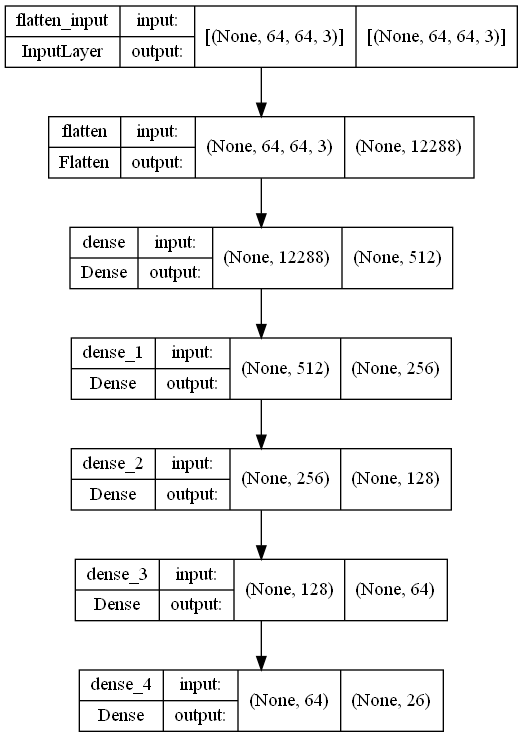

In [8]:
#generating model
model = keras.Sequential([
    layers.Flatten(input_shape=[64, 64, 3]),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(26, activation="softmax"),
])
model.summary()
plot_model(model,show_shapes=True, show_layer_names=True)

In [9]:
#compiling model
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.SGD(),                    
              metrics=[keras.metrics.SparseCategoricalAccuracy()]) 

In [ ]:
model.fit(train_batched, epochs=1,verbose=2)